# Text Generation using sequence-to-sequence with Keras

Author: [Valentin Malykh](http://val.maly.hk)

## Attention Explained
If we want to undertand something then paying attention is really helpful. In Neural Networks, it is also true if we can identify the most critical or important things to pay attention to. You can find the resources on [attention](http://ruder.io/deep-learning-nlp-best-practices/index.html#attention) and current best practices for NLP in general. Mathematically we can also visualize attention with the following image:

<p align="center">
  <img src="https://github.com/philipperemy/keras-attention-mechanism/blob/master/assets/attention_1.png?raw=true" width="400">
</p>


We can see the big spike is where the attention of the model will be directed.

In [2]:
from keras.layers import Embedding, Bidirectional
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers.merge import Multiply
from keras.utils import to_categorical
from keras.layers import TimeDistributed

import keras.backend as K
import numpy as np

Function to get activations of attention layer:

In [3]:
def get_activations(model, inputs, layer_name=None):
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
    return activations

Generation of simple random dataset for attention

In [4]:
def get_data_recurrent(n, time_steps, input_dim, attention_column=None):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    if attention_column is None:
        attention_column = np.random.randint(low=0, high=input_dim)
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y

In [5]:
INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False

The Attention itself:

In [6]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = Multiply(name='attention_mul')([inputs, a_probs])
    return output_attention_mul

Two models with attention, you could try both.

In [7]:
def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

In [8]:
def model_attention_applied_before_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model

Generate data and compile model:

In [10]:
N = 300000
inputs_1, outputs = get_data_recurrent(N, TIME_STEPS, INPUT_DIM)

if APPLY_ATTENTION_BEFORE_LSTM:
    m = model_attention_applied_after_lstm()
else:
    m = model_attention_applied_before_lstm()

m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(m.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 2)        0                                            
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 2, 20)        0           input_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 2, 20)        0           permute_2[0][0]                  
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2, 20)        420         reshape_2[0][0]                  
__________________________________________________________________________________________________
attention_

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  import sys


Fit model and get the attention visualization:

Train on 270000 samples, validate on 30000 samples
Epoch 1/1
270000/270000 [==============================] - 26s - loss: 0.4737 - acc: 0.7406 - val_loss: 0.5819 - val_acc: 0.6424


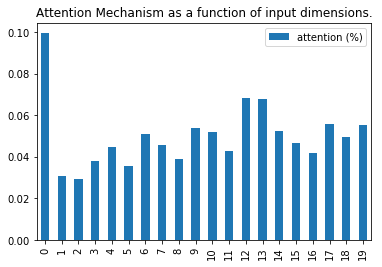

In [12]:
m.fit([inputs_1], outputs, epochs=1, batch_size=512, validation_split=0.1)

attention_vectors = []
for i in range(300):
    testing_inputs_1, testing_outputs = get_data_recurrent(1, TIME_STEPS, INPUT_DIM)
    attention_vector = np.mean(get_activations(m,
                                               testing_inputs_1,
                                               layer_name='attention_vec')[0], axis=2).squeeze()
    # print('attention =', attention_vector)
    assert (np.sum(attention_vector) - 1.0) < 1e-5
    attention_vectors.append(attention_vector)

attention_vector_final = np.mean(np.array(attention_vectors), axis=0)
# plot part.
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar',
                                                                     title='Attention Mechanism as '
                                                                           'a function of input'
                                                                           ' dimensions.')
plt.show()

## New task - translation

The machine translation is old and well-known field in natural language processing. From the 1950s scientists tried to create a model to automatically translate from say French to English. Nowadays it became possible and the attention mechanism takes great part in that. Here the example image with attention map for the neural machine translation of sample phrase:
<p align="center">
  <img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/12/Screen-Shot-2015-12-30-at-1.23.48-PM.png" width="400">
</p>

In our lab we will concentrate on much simplier task: we will translate from human readable date to machine readable one.

To do this we need to get one more concept - Sequence-to-Sequence language modeling.
The idea of such architecture is here:
<p aling="center">
<img src="https://talbaumel.github.io/attention/img/birnn.jpg" width="400">
</p>

There is an Embeding layer at the bottom, the bidirectional RNN in the middle and softmax as an output.

In [13]:
ENCODER_UNITS = 32
DECODER_UNITS = 32

Here we use more complex idea that simple seq2seq: we're adding two explicit parts of our network - encoder and decoder (which is applied attention on). The explanatory picture for this idea is below:
<p aling="center"><img src="https://i.stack.imgur.com/Zwsmz.png"></p>

The lower part of the network is encoding the input to some hidden intermediate representation and the upper part is decoing the hidвen representation into some readable output.

Finally, lets create a machine translation model:

In [15]:
def model_simple_nmt(in_chars, out_chars):
    inputs = Input(shape=(TIME_STEPS,))
    
    input_embed = Embedding(in_chars, ENCODER_UNITS * 2, input_length=TIME_STEPS, trainable=True,
                            name='embedding')(inputs)
    
    enc_out = Bidirectional(LSTM(ENCODER_UNITS, return_sequences=True))(input_embed)
    dec_out = LSTM(DECODER_UNITS, return_sequences=True)(enc_out)
    attention_mul = attention_3d_block(dec_out)
    
    output = TimeDistributed(Dense(out_chars, activation='softmax'))(attention_mul)
   
    model = Model(input=[inputs], output=output)
    return model

Now we need to generate data. It will be dates in different text formats and in fixed output format.

In [16]:
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
import numpy as np

In [17]:
fake = Faker()
fake.seed(12345)
random.seed(12345)

FORMATS = ['short',
           'medium',
           'long',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

# change this if you want it to work with another language
LOCALES = ['en_US']

In [18]:
def create_date():
    """
        Creates some fake dates 
        :returns: tuple containing human readable string, machine readable string, and date object
    """
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS), locale=random.choice(LOCALES))

        case_change = random.choice([0,1,2])
        if case_change == 1:
            human_readable = human_readable.upper()
        elif case_change == 2:
            human_readable = human_readable.lower()
        # if case_change == 0, do nothing

        machine_readable = dt.isoformat()
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

In [19]:
def create_dataset(n_examples):
    """
        Creates a dataset with n_examples and vocabularies
        :n_examples: the number of examples to generate
    """
    human_vocab = set()
    machine_vocab = set()
    dataset = []

    for i in tqdm(range(n_examples)):
        h, m, _ = create_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))

    human = dict(zip(list(human_vocab) + ['<unk>', '<pad>'], 
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(list(machine_vocab) + ['<unk>', '<pad>']))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

In [20]:
def string_to_int(string, lenght, vocab):
    if len(string) > lenght:
        string = string[:lenght]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < lenght:
        rep += [vocab['<pad>']] * (lenght - len(string))
    
    return rep

In [21]:
def int_to_string(ints, inv_vocab):
    return [inv_vocab[i] for i in ints]

Actually generating data:

In [22]:
N = 300000
dataset, human_vocab, machine_vocab, inv_machine_vocab = create_dataset(N)

100%|██████████| 300000/300000 [00:28<00:00, 10396.21it/s]


Compiling and training model:

In [23]:
m = model_simple_nmt(len(human_vocab), len(machine_vocab))

m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(m.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 64)       3840        input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 64)       24832       embedding[0][0]                  
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 20, 32)       12416       bidirectional_1[0][0]            
__________________________________________________________________________________________________
permute_3 

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ti..., inputs=[<tf.Tenso...)`
  del sys.path[0]


In [ ]:
inputs, targets = zip(*dataset)
inputs = np.array([string_to_int(i, TIME_STEPS, human_vocab) for i in inputs])
targets = [string_to_int(t, TIME_STEPS, machine_vocab) for t in targets]
targets = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), targets)))

In [ ]:
m.fit([inputs], targets, epochs=1, batch_size=64, validation_split=0.1)

Train on 270000 samples, validate on 30000 samples
Epoch 1/1
  6144/270000 [..............................] - ETA: 587s - loss: 2.2867 - acc: 0.4980

Lets check our model:

In [ ]:
EXAMPLES = ['3 May 1979', '5 Apr 09', '20th February 2016', 'Wed 10 Jul 2007']

def run_example(model, input_vocabulary, inv_output_vocabulary, text):
    encoded = string_to_int(text, TIME_STEPS, input_vocabulary)
    prediction = model.predict(np.array([encoded]))
    prediction = np.argmax(prediction[0], axis=-1)
    return int_to_string(prediction, inv_output_vocabulary)

def run_examples(model, input_vocabulary, inv_output_vocabulary, examples=EXAMPLES):
    predicted = []
    for example in examples:
        predicted.append(''.join(run_example(model, input_vocabulary, inv_output_vocabulary, example)))
        print('input:', example)
        print('output:', predicted[-1])
    return predicted

In [ ]:
run_examples(m, human_vocab, inv_machine_vocab)

And visualize the actual attention map on some example:

In [ ]:
def attention_map(model, input_vocabulary, inv_output_vocabulary, text):
    """
        visualization of attention map
    """
    # encode the string
    encoded = string_to_int(text, TIME_STEPS, input_vocabulary)

    # get the output sequence
    prediction = model.predict(np.array([encoded]))
    predicted_text = np.argmax(prediction[0], axis=-1)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)

    text_ = list(text)
    # get the lengths of the string
    input_length = len(text)
    output_length = predicted_text.index('<pad>')
    # get the activation map
    attention_vector = get_activations(model, [encoded], layer_name='attention_vec')[0].squeeze()
    activation_map = attention_vector[0:output_length, 0:input_length]
    
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Probability', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    f.show()

In [ ]:
attention_map(m, human_vocab, inv_machine_vocab, EXAMPLES[0])

As you probably see, the default model for this lab is not that good. But you could try to improve it by yourself. You could get better results, like this:

<p align="center"><img src="https://user-images.githubusercontent.com/6295292/26899949-bbac0c7c-4b9e-11e7-84d6-c2f31166af07.png" width="800"></p>

## Real Case

### Before doing this part run Kernel->Restart so the GPU memory is completely free.


After the toy examples we finally see what is attention good for. We will try actual Neural Machine Translation model, which is shipped with this lab. This NMT model was trained on German-English corpus, so it will translate from German to English.

But before we start we need to discuss one more think, which is really important in machine translation (and also other NLP tasks), this is BPE representation.

### BPE
BPE stands for byte pair enconding. It means that common byte pairs (bigrams of chars in our case) are replaced by the byte which never occur in the corpus. Say, in our corpus we have never seen "#" char, so we could use it to represent some typical bigram like "ie". But in practive all the printable chars are used, so for BPE the unprintable part of codepage is used. To actually print thу text, we need to reformat it back. so you'll see in text "@@ " - this is artefacts from such renormalisation.

Here we have example text in German, which will be translated in English by our model.

In [ ]:
! head wmt/newstest2015.tok.bpe.32000.de

The actual architecture of used is:
![](../2017-09-14_23-11-48.png)
It is slightly more complex than in our toy example with dates. Hуre we again have encoder-decoder architecture, but the attention now is taken from all the input, not the part of it. And also we use so called context vector which is representation of the whole sentence - it is helpful for the model to "get the idea" of a phrase before translating it.


Lets finally see what our model will give us:

In [ ]:
!python OpenSeq2Seq/run.py --config_file=OpenSeq2Seq/example_configs/nmt.json --logdir=./nmt --mode=infer --inference_out=pred.txt

__Acknowledgements__: code based on keras-visualize-activations of Philippe Remy

URL: https://github.com/philipperemy/keras-visualize-activations

The idea of date translation is borrowed from https://github.com/datalogue/keras-attention.

For the real case we have used https://github.com/NVIDIA/OpenSeq2Seq, NVIDIA's implementation of Seq2Seq model.
